
Training Simple NN ...
Epoch 1: Loss = 214322757.3731
Epoch 10: Loss = 212280076.4179
Epoch 20: Loss = 203840252.1791
Epoch 30: Loss = 189428580.5373
Epoch 40: Loss = 169993124.5373
Epoch 50: Loss = 147367841.6716
Epoch 60: Loss = 123431979.2239
Epoch 70: Loss = 99605578.0299
Epoch 80: Loss = 77767915.7015
Epoch 90: Loss = 59280801.1940
Epoch 100: Loss = 44197216.3582
Simple NN Test R²: 0.0858

Training Deep NN ...
Epoch 1: Loss = 214312947.5821
Epoch 10: Loss = 11313781.7910
Epoch 20: Loss = 5480378.0149
Epoch 30: Loss = 3804391.5905
Epoch 40: Loss = 2797203.4030
Epoch 50: Loss = 2263495.6091
Epoch 60: Loss = 1960278.5896
Epoch 70: Loss = 1653408.2649
Epoch 80: Loss = 1489121.4618
Epoch 90: Loss = 1415746.2444
Epoch 100: Loss = 1221301.9440
Deep NN Test R²: 0.9611

Training Wide NN ...
Epoch 1: Loss = 214290916.2985
Epoch 10: Loss = 197776076.4179
Epoch 20: Loss = 127958345.5522
Epoch 30: Loss = 51375839.0448
Epoch 40: Loss = 18473076.2388
Epoch 50: Loss = 12478272.0896
Epoch 60: Los

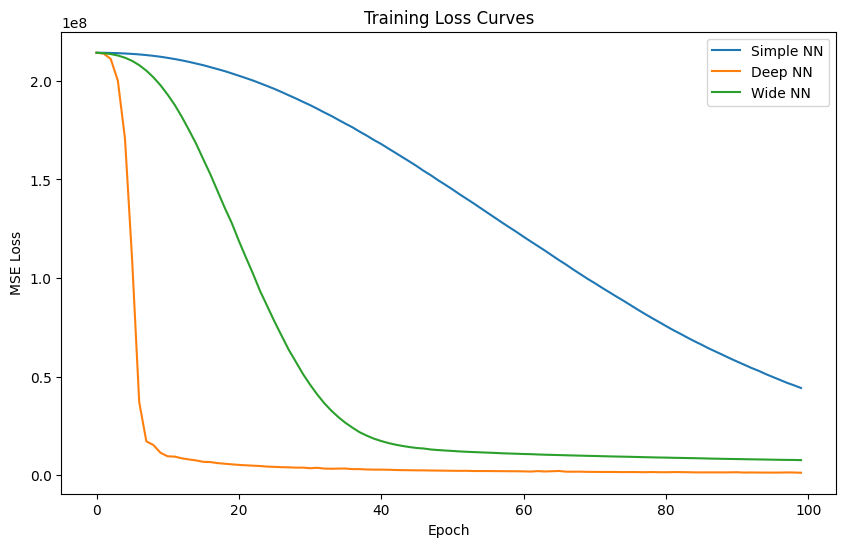

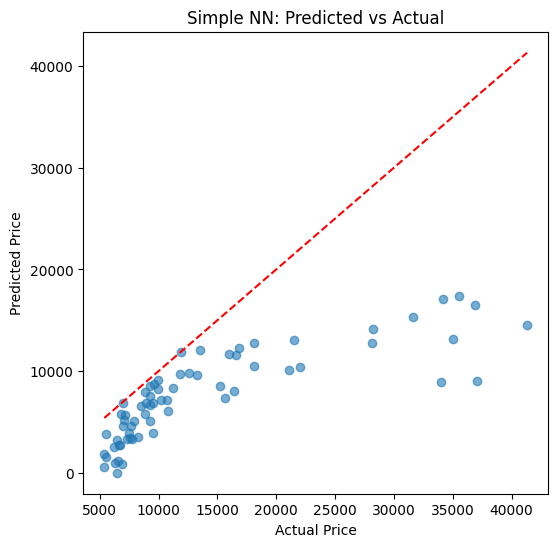

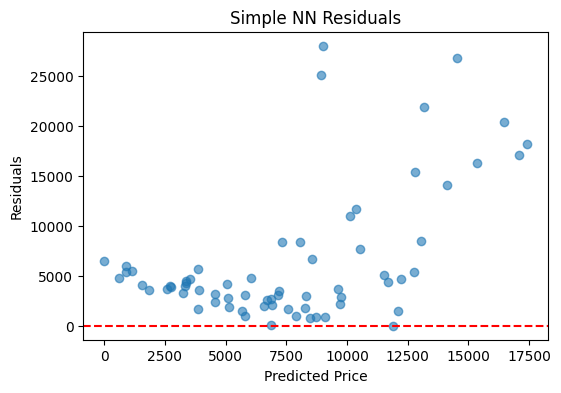

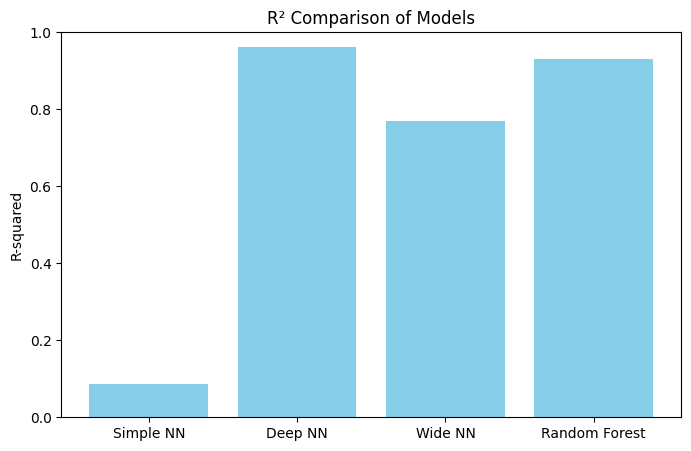

In [7]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# 1. Load dataset
column_names = [
    "symboling", "normalized-losses", "make", "fuel-type", "aspiration",
    "num-of-doors", "body-style", "drive-wheels", "engine-location", "wheel-base",
    "length", "width", "height", "curb-weight", "engine-type", "num-of-cylinders",
    "engine-size", "fuel-system", "bore", "stroke", "compression-ratio",
    "horsepower", "peak-rpm", "city-mpg", "highway-mpg", "price"
]
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data"
df = pd.read_csv(url, names=column_names, na_values='?')

# 2. Drop missing target rows
df = df.dropna(subset=['price'])

# 3. Separate features & target
X = df.drop('price', axis=1)
y = df['price'].astype(float).values

# 4. Identify categorical and numerical columns
cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(include=['number']).columns

# 5. Preprocessing pipelines
numeric_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])
categorical_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encode', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, num_cols),
    ('cat', categorical_pipeline, cat_cols)
])

X_processed = preprocessor.fit_transform(X)

# 6. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.33, random_state=42
)

# 7. Convert to torch tensors
def to_tensor(arr):
    if hasattr(arr, 'todense'):
        arr = arr.todense()
    return torch.tensor(arr, dtype=torch.float32)

X_train_t = to_tensor(X_train)
X_test_t = to_tensor(X_test)
y_train_t = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
y_test_t = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

batch_size = 16
train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 8. Define model architectures
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self,x): return self.net(x)

class DeepNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self,x): return self.net(x)

class WideNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
    def forward(self,x): return self.net(x)

# 9. Generic training function
def train_model(model, train_loader, n_epochs=100, lr=0.005, epsilon=0.0001):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    best_loss = float('inf')

    for epoch in range(n_epochs):
        model.train()
        running_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        if abs(best_loss - epoch_loss) < epsilon:
            print(f"Early stopping at epoch {epoch+1}")
            break
        if epoch_loss < best_loss:
            best_loss = epoch_loss

        if (epoch+1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}: Loss = {epoch_loss:.4f}")
    return train_losses

# 10. Evaluation function including R2 and predictions
def evaluate_model(model, test_loader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            out = model(xb).cpu().numpy()
            preds.extend(out.flatten())
            targets.extend(yb.numpy().flatten())
    r2 = r2_score(targets, preds)
    return preds, targets, r2

# 11. Train all neural nets
input_dim = X_train.shape[1]
models = {
    'Simple NN': SimpleNN(input_dim),
    'Deep NN': DeepNN(input_dim),
    'Wide NN': WideNN(input_dim)
}
histories = {}
results = {}

for name, mdl in models.items():
    print(f"\nTraining {name} ...")
    loss_hist = train_model(mdl, train_dl)
    preds, targets, r2 = evaluate_model(mdl, test_dl)
    histories[name] = loss_hist
    results[name] = {'preds': preds, 'targets': targets, 'r2': r2}
    print(f"{name} Test R²: {r2:.4f}")

# 12. Train classic ML model: Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_r2 = r2_score(y_test, rf_preds)
print(f"\nRandom Forest Test R²: {rf_r2:.4f}")
results['Random Forest'] = {'preds': rf_preds, 'targets': y_test, 'r2': rf_r2}

# 13. Plot training losses
plt.figure(figsize=(10,6))
for name, loss_hist in histories.items():
    plt.plot(loss_hist, label=name)
plt.title("Training Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

# 14. Predicted vs Actual scatter for Simple NN
plt.figure(figsize=(6,6))
plt.scatter(results['Simple NN']['targets'], results['Simple NN']['preds'], alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title("Simple NN: Predicted vs Actual")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.show()

# 15. Residual plot for Simple NN
residuals = results['Simple NN']['targets'] - np.array(results['Simple NN']['preds'])
plt.figure(figsize=(6,4))
plt.scatter(results['Simple NN']['preds'], residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.title("Simple NN Residuals")
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.show()

# 16. Bar chart of R² scores
model_names = list(results.keys())
r2_scores = [results[name]['r2'] for name in model_names]

plt.figure(figsize=(8,5))
plt.bar(model_names, r2_scores, color='skyblue')
plt.title("R² Comparison of Models")
plt.ylabel("R-squared")
plt.ylim(0, 1)
plt.show()
